In [1]:
import warnings
warnings.filterwarnings('ignore')

import random

from keras.preprocessing.image import ImageDataGenerator  # DATA AUGMNETATION
from keras.preprocessing.image import load_img,img_to_array

import numpy  as np
import os
import pandas as pd
import shutil
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img,img_to_array
import keras
from keras.models import Model
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers, optimizers
from keras.layers import Dense,Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from keras.models import model_from_json
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Activation,
from keras.models import model_from_json



Using TensorFlow backend.


In [22]:
import cv2

In [2]:
os.chdir('C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA')

In [3]:
os.getcwd()

'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA'

In [4]:
labels=[]
root_folders=[]
for root,dir,filenames in os.walk(os.getcwd()):
    for i in dir:
        if i != None and i not in ['COVID','NON_COVID']:
            labels.append(i)
    root_folders.append(root)
        

In [5]:
root_folders = [i for i in root_folders if  not i.split('\\')[-1] in [ 'DATA']]
root_folders

['C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_0',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_1',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_10',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_11',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_12',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_13',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_14',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_15',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_16',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\D

In [6]:
labels_and_folders=[(i,j) for i,j in zip(labels,root_folders)]

In [7]:
labels_and_folders[0]

('non_covid_Patient_0',
 'C:\\Users\\anish_yagt7hg\\Desktop\\internship\\COVID-19_CLASSIFICATION\\DATA\\non_covid_Patient_0')

In [8]:
def folders(label,path):
    folder =[os.path.join(path+'\\'+ file) for file in os.listdir(path)]
    return folder

In [49]:
def READ_IMAGES(data):
    
    for img in range(len(data)):
        data[img] = load_img(data[img],target_size=(224,224,3),color_mode='rgb')     # REDAING IMAGES IN RGB MODE and#    RESIZING IMAGE INTO (224 X 224 x3)
        data[img] = img_to_array(data[img])
        data[img] = data[img]/255                                 #   scaling the value between 0 and 1
        data[img] = cv2.pow(data[img],0.6)                        # applying power transformation for enhancing images 
    return np.array(data)
        

In [61]:
def Label(label):
        if label.startswith('non_covid_Patient'):
            return 0
        else:
            return 1


In [63]:
def process(label,path):
    folder =folders(label,path)
    img_list=READ_IMAGES(folder)
    img_list=np.array(img_list)
    img_features =np.mean(img_list,axis=0)
    target_label = Label(label)
    return img_features,target_label 

In [64]:
data=[]
for i,j in labels_and_folders:
        data.append(process(i,j))

In [69]:
data[-1][0].shape

(224, 224, 3)

In [70]:
len(data)

304

In [71]:
target_label_squeezenet_mean =[j for i,j in data]
target_label_squeezenet_mean=to_categorical(target_label_squeezenet_mean)
features_mean_squeeze_net=[i for i,j in data]


In [72]:
print(len(target_label_squeezenet_mean),len(features_mean_squeeze_net))

304 304


In [75]:
squeezenet_mean_X_train,squeezenet_mean_X_test,squeezenet_mean_Y_train,squeezenet_mean_Y_test = train_test_split(
    features_mean_squeeze_net,target_label_squeezenet_mean,test_size=0.2,random_state=141890)

print("THE NO.of Images in Training Data are : {} ".format(len(squeezenet_mean_X_train)))
print("THE NO.of Images in VALIDATION Data are : {} ".format(len(squeezenet_mean_X_test)))


THE NO.of Images in Training Data are : 243 
THE NO.of Images in VALIDATION Data are : 61 


In [76]:
squeezenet_mean_X_train[0].shape


(224, 224, 3)

In [90]:
squeezenet_mean_Y_train[0]

array([0., 1.], dtype=float32)

In [77]:
squeezenet_mean_X_train =np.array(squeezenet_mean_X_train)
squeezenet_mean_X_test =np.array(squeezenet_mean_X_test)

In [78]:
def squeezenet(input_shape, n_classes):
    def fire(x, fs, fe):
        s = Conv2D(fs, 1, activation='relu')(x)
        e1 = Conv2D(fe, 1, activation='relu')(s)
        e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
        output = Concatenate()([e1, e3])
        return output
    input = Input(input_shape)

    x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = fire(x, 16, 64)
    x = fire(x, 16, 64)
    x = fire(x, 32, 128)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = fire(x, 32, 128)
    x = fire(x, 48, 192)
    x = fire(x, 48, 192)
    x = fire(x, 64, 256)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = fire(x, 64, 256)
    x = Conv2D(n_classes, 1)(x)
    x = GlobalAvgPool2D()(x)

    output = Activation('sigmoid')(x)

    model = Model(input, output)
    return model

In [79]:
model = squeezenet((224,224,3),2)

Instructions for updating:
Colocations handled automatically by placer.


In [82]:
#OPtimizers
adam = keras.optimizers.Adam(lr=0.01, decay=0.0005)

## Callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(patience=5, verbose=1)

## Compiling the model and defining loss function
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

## Training neural nets
history=model.fit(squeezenet_mean_X_train,squeezenet_mean_Y_train,validation_data=(squeezenet_mean_X_test,squeezenet_mean_Y_test),
                                              epochs=100, batch_size=32,
                                              callbacks=[reduce_lr, earlystopper])

Train on 243 samples, validate on 61 samples
Epoch 1/100
243/243 [==============================] - 50s 207ms/step - loss: 0.8829 - acc: 0.7119 - val_loss: 0.6469 - val_acc: 0.6557
Epoch 2/100
243/243 [==============================] - 51s 212ms/step - loss: 0.6625 - acc: 0.7119 - val_loss: 0.6524 - val_acc: 0.6557
Epoch 3/100
243/243 [==============================] - 49s 201ms/step - loss: 0.8192 - acc: 0.7119 - val_loss: 0.6457 - val_acc: 0.6557
Epoch 4/100
243/243 [==============================] - 47s 195ms/step - loss: 0.6144 - acc: 0.7119 - val_loss: 0.6445 - val_acc: 0.6557
Epoch 5/100
243/243 [==============================] - 46s 188ms/step - loss: 0.5989 - acc: 0.7119 - val_loss: 0.6715 - val_acc: 0.6557
Epoch 6/100
243/243 [==============================] - 48s 196ms/step - loss: 0.6085 - acc: 0.7119 - val_loss: 0.6501 - val_acc: 0.6557
Epoch 7/100
243/243 [==============================] - 45s 186ms/step - loss: 0.6022 - acc: 0.7119 - val_loss: 0.6555 - val_acc: 0.6557
Epo

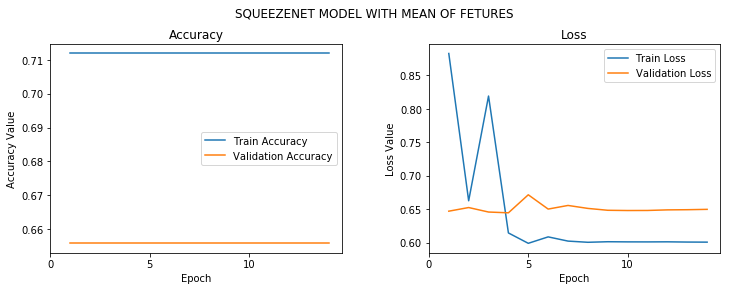

In [83]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('SQUEEZENET MODEL WITH MEAN OF FETURES', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,15))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list,history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 15, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 15, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [94]:
squeezenet_mean_pred_train =np.argmax(model.predict(squeezenet_mean_X_train),axis=1)
squeezenet_mean_pred_test =np.argmax(model.predict(squeezenet_mean_X_test),axis=1)


In [95]:
squeezenet_labels_mean_train = np.argmax(squeezenet_mean_Y_train,axis=1)
squeezenet_labels_mean_test = np.argmax(squeezenet_mean_Y_test,axis=1)


In [96]:
print("ACCURACY SCORE OF SQUEEZENET with MEAN OF FEATURES ON TRAINING SET IS :{}".
      format(accuracy_score(squeezenet_labels_mean_train,squeezenet_mean_pred_train)))
      
      
print("ACCURACY SCORE OF SQUEEZENET with MEAN OF FEATURES ON TEST SET IS :{}".
      format(accuracy_score(squeezenet_labels_mean_test,squeezenet_mean_pred_test)))
      
      
            

ACCURACY SCORE OF SQUEEZENET with MEAN OF FEATURES ON TRAINING SET IS :0.7119341563786008
ACCURACY SCORE OF SQUEEZENET with MEAN OF FEATURES ON TEST SET IS :0.6557377049180327


#### SAVING WEIGHTS AND MODEL

In [97]:
# serialize model to JSON
model_json = model.to_json()
with open("squeezenet_model_mean.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("squeezenet_model_mean.h5")
print("Saved model to disk")


Saved model to disk


#### EXPERIMENTS WITH MEDIAN OF FEATURES

In [98]:
def process1(label,path):
    folder =folders(label,path)
    img_list=READ_IMAGES(folder)
    img_list=np.array(img_list)
    img_features =np.median(img_list,axis=0)
    target_label = Label(label)
    return img_features,target_label 

In [99]:
data1=[]
for i,j in labels_and_folders:
        data1.append(process1(i,j))

In [100]:
target_label_squeezenet_median =[j for i,j in data1]
target_label_squeezenet_median=to_categorical(target_label_squeezenet_median)
features_median_squeeze_net=[i for i,j in data1]


In [102]:
print(len(target_label_squeezenet_median),len(features_median_squeeze_net))

304 304


In [103]:
squeezenet_median_X_train,squeezenet_median_X_test,squeezenet_median_Y_train,squeezenet_median_Y_test = train_test_split(
    features_median_squeeze_net,target_label_squeezenet_median,test_size=0.2,random_state=141899)

print("THE NO.of Images in Training Data are : {} ".format(len(squeezenet_median_X_train)))
print("THE NO.of Images in VALIDATION Data are : {} ".format(len(squeezenet_median_X_test)))


THE NO.of Images in Training Data are : 243 
THE NO.of Images in VALIDATION Data are : 61 


In [106]:
squeezenet_median_X_train =np.array(squeezenet_median_X_train)
squeezenet_median_X_test =np.array(squeezenet_median_X_test)

In [107]:
model1= squeezenet((224,224,3),2)

In [108]:
#OPtimizers
adam = keras.optimizers.Adam(lr=0.0001, decay=0.00005)

## Callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(patience=5, verbose=1)

## Compiling the model and defining loss function
model1.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

## Training neural nets
history1=model1.fit(squeezenet_median_X_train,squeezenet_median_Y_train,validation_data=(squeezenet_median_X_test,squeezenet_median_Y_test),
                                              epochs=100, batch_size=32,
                                              callbacks=[reduce_lr, earlystopper])

Train on 243 samples, validate on 61 samples
Epoch 1/100
243/243 [==============================] - 47s 195ms/step - loss: 0.6922 - acc: 0.6749 - val_loss: 0.6897 - val_acc: 0.7213
Epoch 2/100
243/243 [==============================] - 46s 188ms/step - loss: 0.6867 - acc: 0.6955 - val_loss: 0.6730 - val_acc: 0.7213
Epoch 3/100
243/243 [==============================] - 45s 187ms/step - loss: 0.6506 - acc: 0.6955 - val_loss: 0.5952 - val_acc: 0.7213
Epoch 4/100
243/243 [==============================] - 45s 186ms/step - loss: 0.6133 - acc: 0.6955 - val_loss: 0.5789 - val_acc: 0.7213
Epoch 5/100
243/243 [==============================] - 45s 183ms/step - loss: 0.6134 - acc: 0.6955 - val_loss: 0.5918 - val_acc: 0.7213
Epoch 6/100
243/243 [==============================] - 43s 178ms/step - loss: 0.6125 - acc: 0.6955 - val_loss: 0.5853 - val_acc: 0.7213
Epoch 7/100
243/243 [==============================] - 43s 177ms/step - loss: 0.6124 - acc: 0.6955 - val_loss: 0.5755 - val_acc: 0.7213
Epo

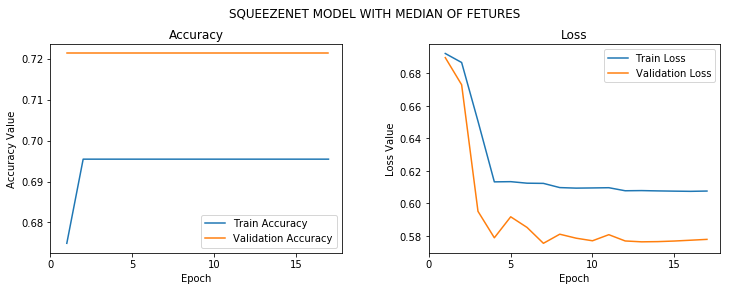

In [109]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('SQUEEZENET MODEL WITH MEDIAN OF FETURES', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,18))
ax1.plot(epoch_list, history1.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list,history1.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 18, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 18, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [110]:
squeezenet_median_pred_train =np.argmax(model1.predict(squeezenet_median_X_train),axis=1)
squeezenet_median_pred_test =np.argmax(model1.predict(squeezenet_median_X_test),axis=1)


In [111]:
squeezenet_labels_median_train = np.argmax(squeezenet_median_Y_train,axis=1)
squeezenet_labels_median_test = np.argmax(squeezenet_median_Y_test,axis=1)


In [112]:
print("ACCURACY SCORE OF SQUEEZENET with MEDIAN OF FEATURES ON TRAINING SET IS :{}".
      format(accuracy_score(squeezenet_labels_median_train,squeezenet_median_pred_train)))
      
      
print("ACCURACY SCORE OF SQUEEZENET with MEDIAN OF FEATURES ON TEST SET IS :{}".
      format(accuracy_score(squeezenet_labels_median_test,squeezenet_median_pred_test)))
      
      
            

ACCURACY SCORE OF SQUEEZENET with MEDIAN OF FEATURES ON TRAINING SET IS :0.6954732510288066
ACCURACY SCORE OF SQUEEZENET with MEDIAN OF FEATURES ON TEST SET IS :0.7213114754098361


In [113]:
# serialize model to JSON
model_json = model1.to_json()
with open("squeezenet_model_median.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("squeezenet_model_median.h5")
print("Saved model to disk")


Saved model to disk
